In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
from scipy import stats
import datetime as dt
import scipy.interpolate as interpolate
from mySSA import mySSA

In [2]:
volc = np.genfromtxt('nature14565-s6_sigl2015.csv', delimiter=",", dtype=float)
data_sinha_2015 = np.genfromtxt('ncomms7309-s3_sinha_sahiya_cave_im2015.csv', delimiter=",", dtype=float) # ismr reconstruction

In [3]:
yy_sinha_ann = np.arange(np.trunc(np.min(data_sinha_2015[:,0])),np.trunc(np.max(data_sinha_2015[:,0])))
ismr_sinha_ann = np.zeros((yy_sinha_ann.shape[0]))

f = interpolate.interp1d(np.flip(data_sinha_2015[:,0]), np.flip(data_sinha_2015[:,1]), kind='linear')
for i in range(yy_sinha_ann.shape[0]):
    ismr_sinha_ann[i] = f(yy_sinha_ann[i])


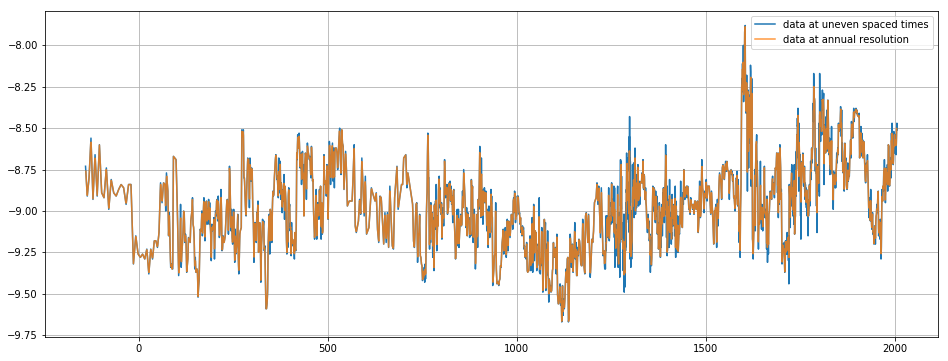

In [4]:
plt.figure(figsize=(16,6))
plt.plot(data_sinha_2015[:,0], data_sinha_2015[:,1], label='data at uneven spaced times')
plt.plot(yy_sinha_ann, ismr_sinha_ann, label='data at annual resolution', alpha=0.8)
plt.legend()
plt.grid()

Negative delta 18 O values correspond to positive ISMR. <br /> The long-term non-stationary trends in both time series are removed by subtracting the first reconstructed component indicated by SSA of the raw data. The two dashed horizontal lines delineate a 10% change in monsoon rainfall amounts, highlighting the magnitude of multi-decadal variability inferred from our NI δ18O record.
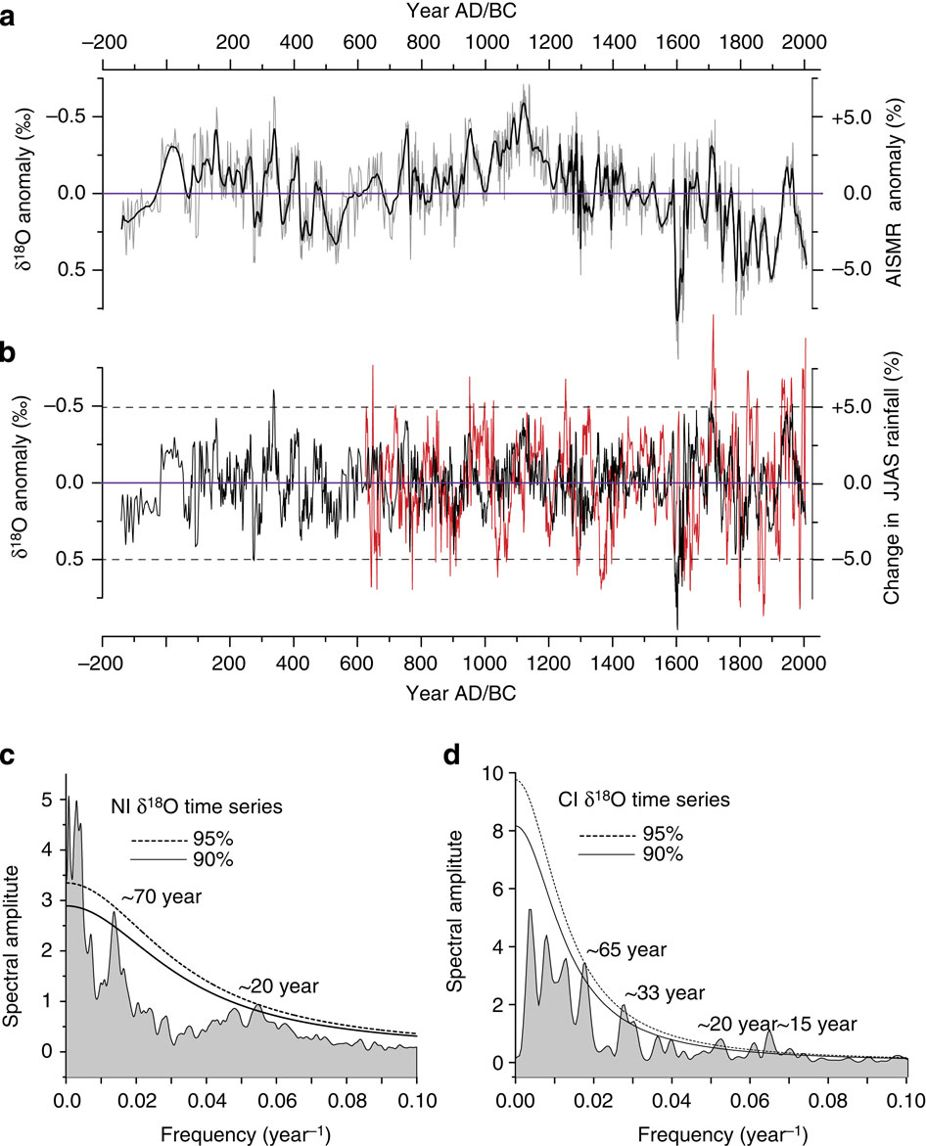

In [5]:
# Singular Spectral Analysis as in Sinha et al 2015
def X_to_TS(X_i):
    """Averages the anti-diagonals of the given elementary matrix, X_i, and returns a time series."""
    # Reverse the column ordering of X_i
    X_rev = X_i[::-1]
    # Full credit to Mark Tolonen at https://stackoverflow.com/a/6313414 for this one:
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

def ssa(F):
    N = F.shape[0]
    L = 160# The window length.
    K = N - L + 1 # The number of columns in the trajectory matrix.
    # Create the trajectory matrix by pulling the relevant subseries of F, and stacking them as columns.
    X = np.column_stack([F[i:i+L] for i in range(0,K)])
    # Note: the i+L above gives us up to i+L-1, as numpy array upper bounds are exclusive. 
    d = np.linalg.matrix_rank(X) # The intrinsic dimensionality of the trajectory space.
    U, Sigma, V = np.linalg.svd(X)
    V = V.T # Note: the SVD routine returns V^T, not V, so I'll tranpose it back here. This may seem pointless, 
    X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )
    n = min(12,d) # In case of noiseless time series with d < 12.
    # Convert elementary matrices straight to a time series - no need to construct any Hankel matrices.
    F_i = np.zeros((n,N))
    for i in range(n):
        F_i[i,:] = X_to_TS(X_elem[i])
    return F_i


In [6]:
ismr_sinha_ann_ssa = ssa(ismr_sinha_ann)

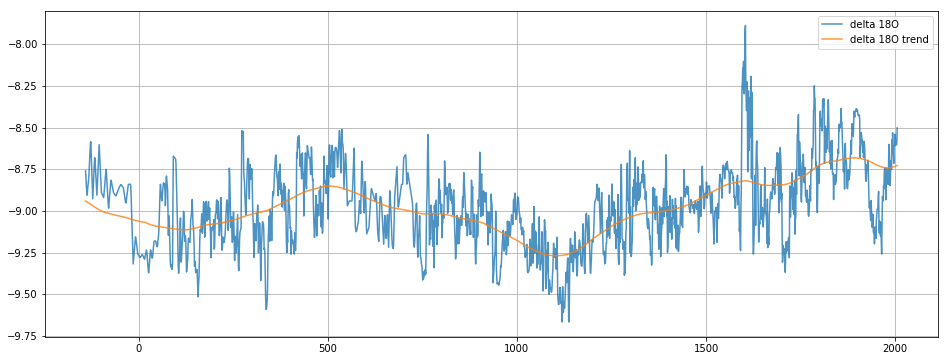

In [7]:
# Trend from Singular Spectral Analysis
plt.figure(figsize=(16,6))
plt.plot(yy_sinha_ann, ismr_sinha_ann, label='delta 18O', alpha=0.8)
plt.plot(yy_sinha_ann, ismr_sinha_ann_ssa[0], label='delta 18O trend', alpha=0.8)
plt.legend()
plt.grid()

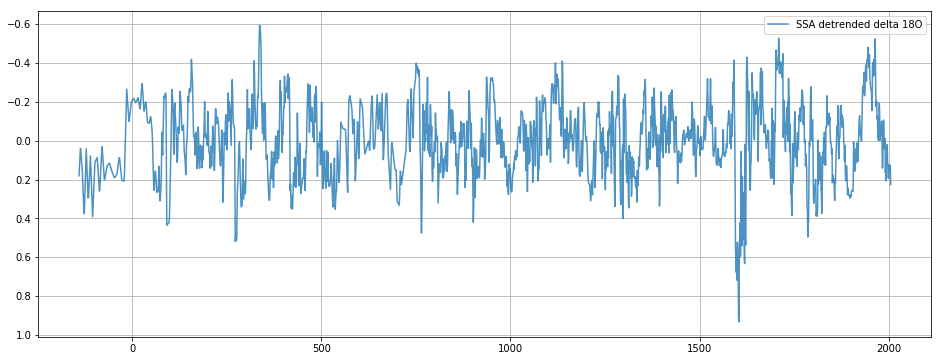

In [8]:
plt.figure(figsize=(16,6))
plt.plot(yy_sinha_ann, ismr_sinha_ann-ismr_sinha_ann_ssa[0], label='SSA detrended delta 18O', alpha=0.8)
plt.legend()
plt.gca().invert_yaxis()
plt.grid()

Plot from comparison in Sinha et al 2015
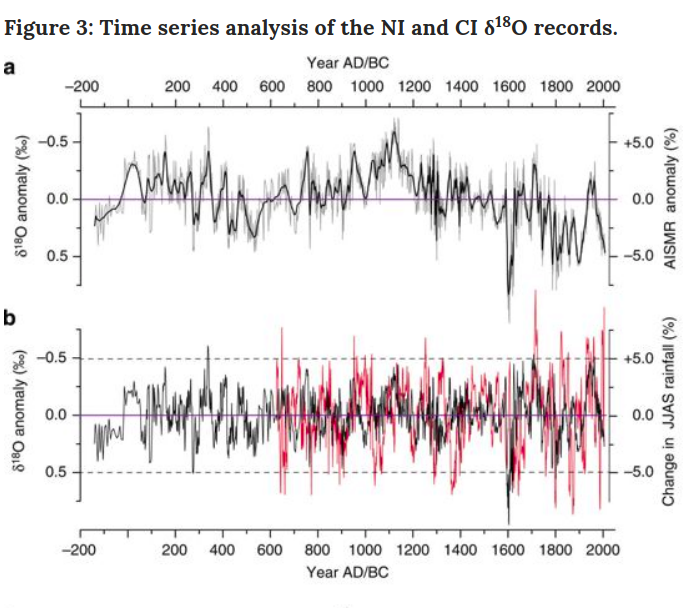

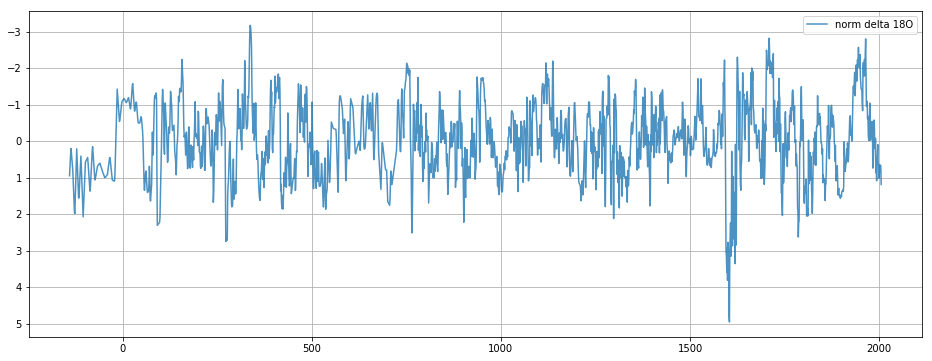

In [9]:
ismr_sinha_ann_ssa_anom = ismr_sinha_ann-ismr_sinha_ann_ssa[0]
ismr_sinha_ann_ssa_anom_norm  = (ismr_sinha_ann_ssa_anom - np.mean(ismr_sinha_ann_ssa_anom))/(np.std(ismr_sinha_ann_ssa_anom))
plt.figure(figsize=(16,6))
plt.plot(yy_sinha_ann, ismr_sinha_ann_ssa_anom_norm, label='norm delta 18O', alpha=0.8)
plt.legend()
plt.gca().invert_yaxis()
plt.grid()

In [10]:
event_drought_sinha = np.zeros((yy_sinha_ann.shape[0]))
event_yy_volc_all = np.zeros((yy_sinha_ann.shape[0]))
event_yy_volc_strong = np.zeros((yy_sinha_ann.shape[0]))
event_yy_volc_all_trop = np.zeros((yy_sinha_ann.shape[0]))
event_yy_volc_all_nh = np.zeros((yy_sinha_ann.shape[0]))
event_yy_volc_all_sh = np.zeros((yy_sinha_ann.shape[0]))
event_yy_volc_strong_trop = np.zeros((yy_sinha_ann.shape[0]))
event_yy_volc_strong_nh = np.zeros((yy_sinha_ann.shape[0]))
event_yy_volc_strong_sh = np.zeros((yy_sinha_ann.shape[0]))

In [11]:
event_drought_sinha[ismr_sinha_ann_ssa_anom_norm>1.0] = 1.0

for i in range(yy_sinha_ann.shape[0]):
    #print(event_yy_kobb[i])
    idx = np.asarray(np.where(volc[:,0] == yy_sinha_ann[i]))
    #print(idx.size)
    if idx.size==0:
        continue
    event_yy_volc_all[i] = 1.0
    if np.abs(volc[idx[0,0],2])>=1.0:
        event_yy_volc_strong[i] = 5.0
    
    if volc[idx[0,0],1] == 1.0:
        event_yy_volc_all_trop[i] = 1.0
    if volc[idx[0,0],1] == 2.0:
        event_yy_volc_all_nh[i] = 1.0
    if volc[idx[0,0],1] == 3.0:
        event_yy_volc_all_sh[i] = 1.0
        
    if (volc[idx[0,0],1] == 1.0) & (np.abs(volc[idx[0,0],2])>=3.7):
        event_yy_volc_strong_trop[i] = 1.0
    if (volc[idx[0,0],1] == 2.0) & (np.abs(volc[idx[0,0],2])>=3.7):
        event_yy_volc_strong_nh[i] = 1.0
    if (volc[idx[0,0],1] == 3.0) & (np.abs(volc[idx[0,0],2])>=3.7):
        event_yy_volc_strong_sh[i] = 1.0

In [12]:
np.savetxt('drought_sinha_2015.txt', event_drought_sinha, delimiter=",")
np.savetxt('all_volc_sinha_2015.txt', event_yy_volc_all, delimiter=",")
np.savetxt('strong_volc_sinha_2015.txt', event_yy_volc_strong, delimiter=",")
np.savetxt('all_tropical_sinha_2015.txt', event_yy_volc_all_trop, delimiter=",")
np.savetxt('strong_tropical_sinha_2015.txt', event_yy_volc_strong_trop, delimiter=",")
np.savetxt('all_nh_sinha_2015.txt', event_yy_volc_all_nh, delimiter=",")
np.savetxt('strong_nh_sinha_2015.txt', event_yy_volc_strong_nh, delimiter=",")
np.savetxt('all_sh_sinha_2015.txt', event_yy_volc_all_sh, delimiter=",")
np.savetxt('strong_sh_sinha_2015.txt', event_yy_volc_strong_sh, delimiter=",")

In [13]:
print(np.sum(event_yy_volc_all))
print(np.sum(event_yy_volc_strong))
print(np.sum(event_yy_volc_all_trop))
print(np.sum(event_yy_volc_strong_trop))
print(np.sum(event_yy_volc_all_nh))
print(np.sum(event_yy_volc_strong_nh))
print(np.sum(event_yy_volc_all_sh))
print(np.sum(event_yy_volc_strong_sh))

243.0
725.0
65.0
41.0
118.0
10.0
60.0
0.0


In [14]:
# Bootstrap
N = 1000
win = 5
count_elnino_all_volc = np.zeros((N, win))
count_elnino_strong_volc  = np.zeros((N, win))
count_elnino_all_trop  = np.zeros((N, win))
count_elnino_strong_trop  = np.zeros((N, win))
count_elnino_all_nh  = np.zeros((N, win))
count_elnino_strong_nh  = np.zeros((N, win))
count_elnino_all_sh  = np.zeros((N, win))

In [15]:
idx_all = np.asarray(np.where(event_yy_volc_all == 1.0))
idx_strong = np.asarray(np.where(event_yy_volc_strong == 1.0))
idx_all_trop = np.asarray(np.where(event_yy_volc_all_trop == 1.0))
idx_strong_trop = np.asarray(np.where(event_yy_volc_strong_trop == 1.0))
idx_all_nh = np.asarray(np.where(event_yy_volc_all_nh == 1.0))
idx_strong_nh = np.asarray(np.where(event_yy_volc_strong_nh == 1.0))
idx_all_sh = np.asarray(np.where(event_yy_volc_all_sh == 1.0))

In [16]:
print(idx_all[0])

[   1   17   35   40   55   94   96  105  119  132  144  171  198  227
  235  242  254  261  264  283  290  300  304  309  312  332  346  355
  358  366  370  376  384  406  421  439  444  447  450  472  485  493
  498  500  506  509  519  528  533  551  558  563  566  573  592  596
  602  607  609  627  632  641  651  661  668  676  680  687  711  714
  721  729  735  747  766  769  772  777  781  797  811  822  828  834
  838  853  857  865  872  885  889  890  896  904  917  922  940  957
  959  962  967  975  977  981  993  999 1009 1016 1019 1020 1040 1044
 1048 1056 1069 1079 1086 1093 1098 1100 1110 1116 1122 1130 1138 1143
 1151 1157 1160 1168 1179 1197 1204 1207 1232 1248 1255 1258 1267 1277
 1311 1320 1322 1331 1340 1350 1362 1370 1376 1398 1402 1409 1416 1426
 1446 1469 1476 1481 1485 1518 1521 1529 1548 1554 1556 1581 1588 1593
 1598 1603 1610 1617 1618 1620 1642 1645 1652 1668 1677 1681 1694 1707
 1716 1725 1730 1735 1741 1759 1761 1777 1781 1786 1794 1802 1807 1813
 1833 

In [17]:
ismr_sinha_ann_ssa_anom_norm = -ismr_sinha_ann_ssa_anom_norm
niter = 0
while niter<N:
    rand_year_all = random.sample(list(idx_all[0]), 1)
    if (rand_year_all[0]<ismr_sinha_ann_ssa_anom_norm.shape[0]-win):
        count_elnino_all_volc[niter,:] = ismr_sinha_ann_ssa_anom_norm[rand_year_all[0]:rand_year_all[0]+win]
    
    rand_year_strong = random.sample(list(idx_strong[0]), 1)
    if (rand_year_strong[0]<ismr_sinha_ann_ssa_anom_norm.shape[0]-win):
        count_elnino_strong_volc[niter,:] = ismr_sinha_ann_ssa_anom_norm[rand_year_strong[0]:rand_year_strong[0]+win]
    
    rand_year_all_trop = random.sample(list(idx_all_trop[0]), 1)
    if (rand_year_all_trop[0]<ismr_sinha_ann_ssa_anom_norm.shape[0]-win):
        count_elnino_all_trop[niter,:] = ismr_sinha_ann_ssa_anom_norm[rand_year_all_trop[0]:rand_year_all_trop[0]+win]

    rand_year_strong_trop = random.sample(list(idx_strong_trop[0]), 1)
    if (rand_year_strong_trop[0]<ismr_sinha_ann_ssa_anom_norm.shape[0]-win):
        count_elnino_strong_trop[niter,:] = ismr_sinha_ann_ssa_anom_norm[rand_year_strong_trop[0]:rand_year_strong_trop[0]+win]

    rand_year_all_nh = random.sample(list(idx_all_nh[0]), 1)
    if (rand_year_all_nh[0]<ismr_sinha_ann_ssa_anom_norm.shape[0]-win):
        count_elnino_all_nh[niter,:] = ismr_sinha_ann_ssa_anom_norm[rand_year_all_nh[0]:rand_year_all_nh[0]+win]

    rand_year_strong_nh = random.sample(list(idx_strong_nh[0]), 1)
    if (rand_year_strong_nh[0]<ismr_sinha_ann_ssa_anom_norm.shape[0]-win):
        count_elnino_strong_nh[niter,:] = ismr_sinha_ann_ssa_anom_norm[rand_year_strong_nh[0]:rand_year_strong_nh[0]+win]

    rand_year_all_sh = random.sample(list(idx_all_sh[0]), 1)
    if (rand_year_all_sh[0]<ismr_sinha_ann_ssa_anom_norm.shape[0]-win):
        count_elnino_all_sh[niter,:] = ismr_sinha_ann_ssa_anom_norm[rand_year_all_sh[0]:rand_year_all_sh[0]+win]
    
    #print(s[rand_year_all[0]:rand_year_all[0]+win])
    #print(rand_year_all[0])
    niter = niter + 1 

ValueError: Sample larger than population

/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value 

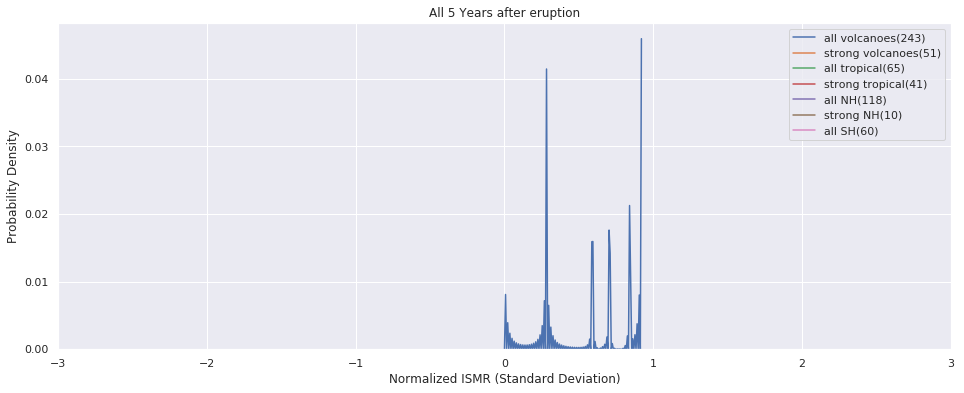

In [18]:
import seaborn as sns; sns.set(color_codes=True)
plt.figure(figsize=(16,6))
sns.kdeplot(count_elnino_all_volc.flatten(), label='all volcanoes(243)')
sns.kdeplot(count_elnino_strong_volc.flatten(), label='strong volcanoes(51)')
sns.kdeplot(count_elnino_all_trop.flatten(), label='all tropical(65)')
sns.kdeplot(count_elnino_strong_volc.flatten(), label='strong tropical(41)')
sns.kdeplot(count_elnino_all_nh.flatten(), label='all NH(118)')
sns.kdeplot(count_elnino_strong_nh.flatten(), label='strong NH(10)')
sns.kdeplot(count_elnino_all_sh.flatten(), label='all SH(60)')
plt.title('All 5 Years after eruption')
plt.ylabel('Probability Density')
plt.xlabel('Normalized ISMR (Standard Deviation)')
plt.xlim([-3,3])
plt.legend()

/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value 

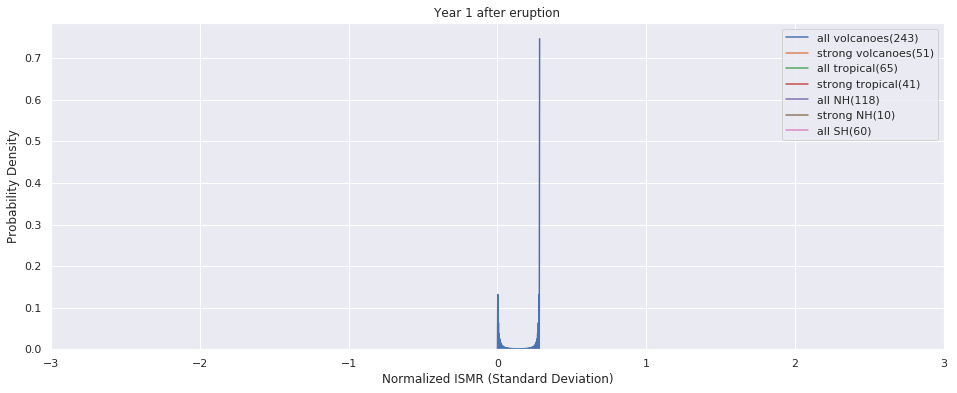

In [19]:
import seaborn as sns; sns.set(color_codes=True)
plt.figure(figsize=(16,6))
sns.kdeplot(count_elnino_all_volc[:,0], label='all volcanoes(243)')
sns.kdeplot(count_elnino_strong_volc[:,0], label='strong volcanoes(51)')
sns.kdeplot(count_elnino_all_trop[:,0], label='all tropical(65)')
sns.kdeplot(count_elnino_strong_volc[:,0], label='strong tropical(41)')
sns.kdeplot(count_elnino_all_nh[:,0], label='all NH(118)')
sns.kdeplot(count_elnino_strong_nh[:,0], label='strong NH(10)')
sns.kdeplot(count_elnino_all_sh[:,0], label='all SH(60)')
plt.title('Year 1 after eruption')
plt.ylabel('Probability Density')
plt.xlabel('Normalized ISMR (Standard Deviation)')
plt.xlim([-3,3])
plt.legend()

/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value 

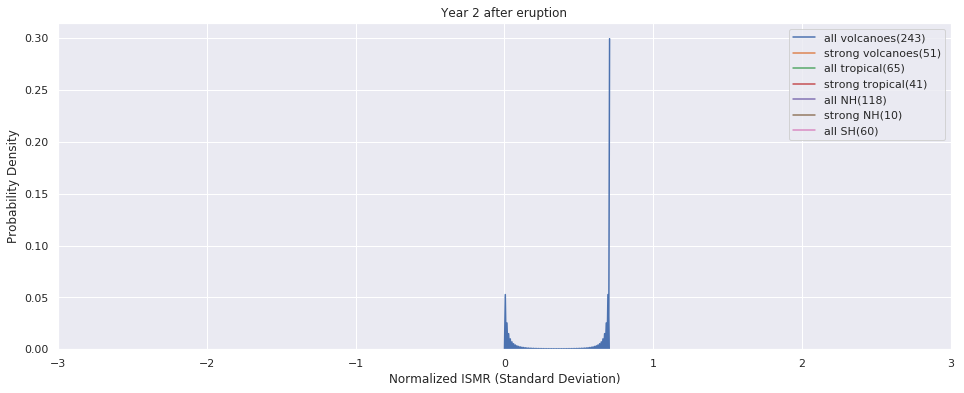

In [20]:
import seaborn as sns; sns.set(color_codes=True)
plt.figure(figsize=(16,6))
sns.kdeplot(count_elnino_all_volc[:,1], label='all volcanoes(243)')
sns.kdeplot(count_elnino_strong_volc[:,1], label='strong volcanoes(51)')
sns.kdeplot(count_elnino_all_trop[:,1], label='all tropical(65)')
sns.kdeplot(count_elnino_strong_volc[:,1], label='strong tropical(41)')
sns.kdeplot(count_elnino_all_nh[:,1], label='all NH(118)')
sns.kdeplot(count_elnino_strong_nh[:,1], label='strong NH(10)')
sns.kdeplot(count_elnino_all_sh[:,1], label='all SH(60)')
plt.title('Year 2 after eruption')
plt.ylabel('Probability Density')
plt.xlabel('Normalized ISMR (Standard Deviation)')
plt.xlim([-3,3])
plt.legend()

/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value 

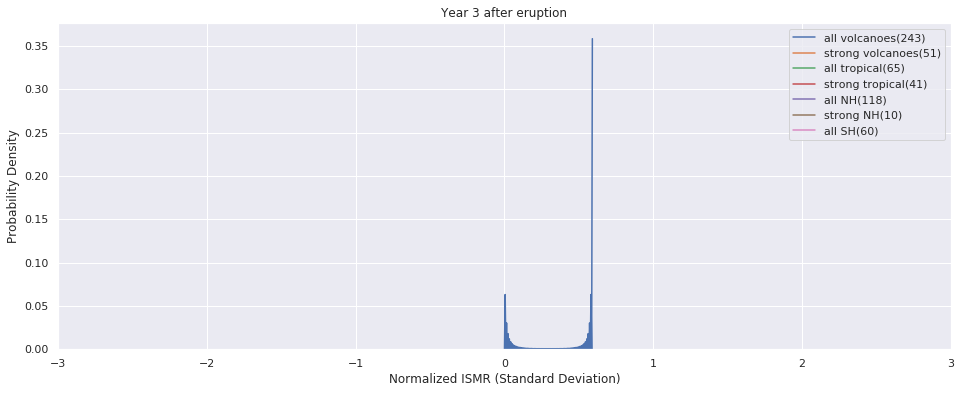

In [21]:
import seaborn as sns; sns.set(color_codes=True)
plt.figure(figsize=(16,6))
sns.kdeplot(count_elnino_all_volc[:,2], label='all volcanoes(243)')
sns.kdeplot(count_elnino_strong_volc[:,2], label='strong volcanoes(51)')
sns.kdeplot(count_elnino_all_trop[:,2], label='all tropical(65)')
sns.kdeplot(count_elnino_strong_volc[:,2], label='strong tropical(41)')
sns.kdeplot(count_elnino_all_nh[:,2], label='all NH(118)')
sns.kdeplot(count_elnino_strong_nh[:,2], label='strong NH(10)')
sns.kdeplot(count_elnino_all_sh[:,2], label='all SH(60)')
plt.title('Year 3 after eruption')
plt.ylabel('Probability Density')
plt.xlabel('Normalized ISMR (Standard Deviation)')
plt.xlim([-3,3])
plt.legend()

/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value 

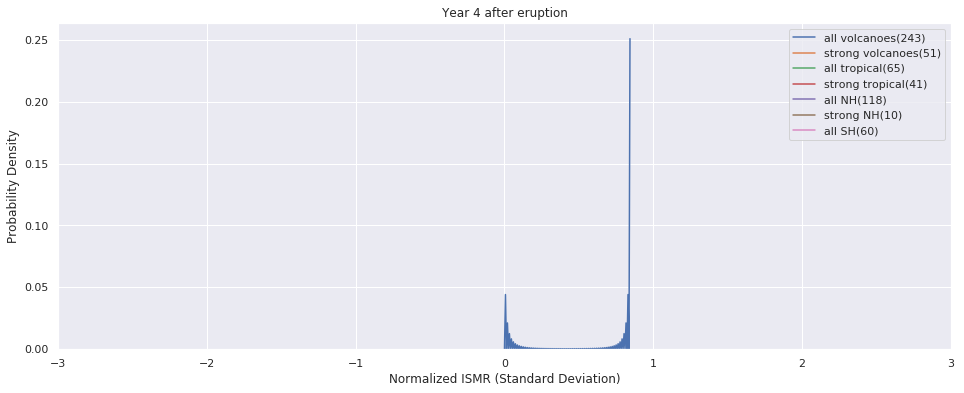

In [22]:
import seaborn as sns; sns.set(color_codes=True)
plt.figure(figsize=(16,6))
sns.kdeplot(count_elnino_all_volc[:,3], label='all volcanoes(243)')
sns.kdeplot(count_elnino_strong_volc[:,3], label='strong volcanoes(51)')
sns.kdeplot(count_elnino_all_trop[:,3], label='all tropical(65)')
sns.kdeplot(count_elnino_strong_volc[:,3], label='strong tropical(41)')
sns.kdeplot(count_elnino_all_nh[:,3], label='all NH(118)')
sns.kdeplot(count_elnino_strong_nh[:,3], label='strong NH(10)')
sns.kdeplot(count_elnino_all_sh[:,3], label='all SH(60)')
plt.title('Year 4 after eruption')
plt.ylabel('Probability Density')
plt.xlabel('Normalized ISMR (Standard Deviation)')
plt.xlim([-3,3])
plt.legend()

/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value 

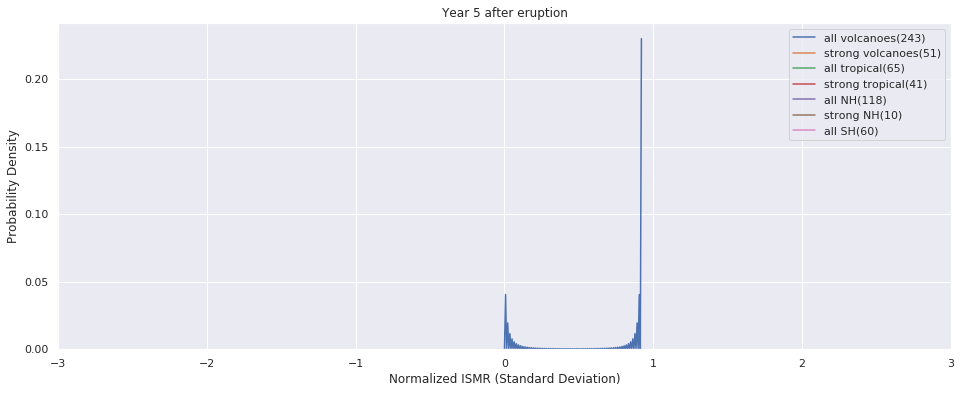

In [23]:
import seaborn as sns; sns.set(color_codes=True)
plt.figure(figsize=(16,6))
sns.kdeplot(count_elnino_all_volc[:,4], label='all volcanoes(243)')
sns.kdeplot(count_elnino_strong_volc[:,4], label='strong volcanoes(51)')
sns.kdeplot(count_elnino_all_trop[:,4], label='all tropical(65)')
sns.kdeplot(count_elnino_strong_volc[:,4], label='strong tropical(41)')
sns.kdeplot(count_elnino_all_nh[:,4], label='all NH(118)')
sns.kdeplot(count_elnino_strong_nh[:,4], label='strong NH(10)')
sns.kdeplot(count_elnino_all_sh[:,4], label='all SH(60)')
plt.title('Year 5 after eruption')
plt.ylabel('Probability Density')
plt.xlabel('Normalized ISMR (Standard Deviation)')
plt.xlim([-3,3])
plt.legend()

In [24]:
ismr_sinha_2015_anom_yy = np.zeros((ismr_sinha_ann_ssa_anom_norm.shape[0],3))
ismr_sinha_2015_anom_yy[:,0] = yy_sinha_ann[:]
ismr_sinha_2015_anom_yy[:,1] = event_yy_volc_strong[:]
ismr_sinha_2015_anom_yy[:,2] = -ismr_sinha_ann_ssa_anom_norm[:]
np.savetxt('ismr_sinha_2015_anom_yy.txt', ismr_sinha_2015_anom_yy, delimiter=",")